In [364]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import kagglehub
import imghdr
from PIL import Image
from torchsummary import summary
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import json
import cv2
from IPython.display import clear_output, FileLink
from sklearn.preprocessing import LabelEncoder
from torchvision import models
from torchvision.models import resnet18, ResNet18_Weights
from sklearn.utils import resample
from torchvision.transforms import Compose, RandomHorizontalFlip, RandomRotation, ColorJitter, Resize
from torchinfo import summary


In [219]:
# Download latest version
path = kagglehub.dataset_download("risangbaskoro/wlasl-processed")

print("Path to dataset files:", path)

Path to dataset files: /Users/wuyuhui/.cache/kagglehub/datasets/risangbaskoro/wlasl-processed/versions/5


In [220]:
# Load JSON file
with open(path + '/WLASL_v0.3.json', 'r') as json_file:
    data = json.load(json_file)

In [221]:
wlas_df = pd.read_json('/Users/wuyuhui/.cache/kagglehub/datasets/risangbaskoro/wlasl-processed/versions/5/WLASL_v0.3.json')
wlas_df.head()

,gloss,instances
0,book,"[{'bbox': [385, 37, 885, 720], 'fps': 25, 'fra..."
1,drink,"[{'bbox': [551, 68, 1350, 1080], 'fps': 25, 'f..."
2,computer,"[{'bbox': [0, 0, 360, 240], 'fps': 25, 'frame_..."
3,before,"[{'bbox': [0, 0, 360, 240], 'fps': 25, 'frame_..."
4,chair,"[{'bbox': [0, 0, 360, 240], 'fps': 25, 'frame_..."


In [222]:
# # Extract gloss and video instances
# video_metadata = []
# for entry in data:  # No need for `data['root']`
#     gloss = entry['gloss']  # Word label
#     for instance in entry['instances']:
#         video_metadata.append({
#             'gloss': gloss,
#             'video_id': instance['video_id']
#         })

# # Example: Print first 5 entries
# print(video_metadata[:5])

In [223]:
def get_videos_ids(json_list):
    """
    function to check if the video id is available in the dataset
    and return the viedos ids of the current instance
    
    input: instance json list
    output: list of videos_ids
    
    """
    videos_list = []    
    for ins in json_list:
        video_id = ins['video_id']
        video_path = os.path.join(path, 'videos', f'{video_id}.mp4')
        if os.path.exists(video_path):
            videos_list.append(video_id)
    return videos_list

In [224]:
def get_json_features(json_list):
    """
    Function to check if the video ID is available in the dataset
    and return the video IDs and URLs or other features of the current instance.
    
    Input: instance JSON list
    Output: tuple of (list of video IDs, list of URLs)
    """
    videos_ids = []
    videos_urls = []
    for ins in json_list:
        video_id = ins['video_id']
        video_url = ins['url']
        video_path = os.path.join(path, 'videos', f'{video_id}.mp4')
        if os.path.exists(video_path):
            videos_ids.append(video_id)
            videos_urls.append(video_url)
    return videos_ids, videos_urls

In [225]:
get_videos_ids(data[0]['instances'])[0]

'69241'

In [226]:
wlas_df['videos_ids'] = wlas_df['instances'].apply(get_videos_ids)

In [227]:
features_list = []  # Use a list to collect data

# Iterate over rows in the DataFrame
for _, row in wlas_df.iterrows():
    # Extract IDs and URLs
    ids, urls = get_json_features(row['instances'])
    
    # Create a temporary list of tuples (gloss, video_id, url)
    word = [(row['gloss'], video_id, url) for video_id, url in zip(ids, urls)]
    features_list.extend(word)  # Append to the main list

# Create a DataFrame from the list
features_df = pd.DataFrame(features_list, columns=['gloss', 'video_id', 'url'])
# Reset the index and add it as a column
features_df = features_df.reset_index()

# Display the resulting DataFrame
print(features_df)

       index       gloss video_id  \
0          0        book    69241   
1          1        book    07069   
2          2        book    07068   
3          3        book    07070   
4          4        book    07099   
...      ...         ...      ...   
11975  11975  wheelchair    63047   
11976  11976  wheelchair    63050   
11977  11977     whistle    63186   
11978  11978     whistle    63188   
11979  11979     whistle    63190   

                                                     url  
0           http://aslbricks.org/New/ASL-Videos/book.mp4  
1      https://signstock.blob.core.windows.net/signsc...  
2      https://s3-us-west-1.amazonaws.com/files.start...  
3      https://media.asldeafined.com/vocabulary/14666...  
4         http://www.aslsearch.com/signs/videos/book.mp4  
...                                                  ...  
11975  https://www.signingsavvy.com/signs/mp4/5/5233.mp4  
11976  http://www.aslsearch.com/signs/videos/wheelcha...  
11977  https://media.spr

In [228]:
features_df.to_csv('features_df.csv', index=False)

# data analysis

In [229]:
wlas_df['samples_num'] = wlas_df['videos_ids'].apply(len)
print(wlas_df.head())

      gloss                                          instances  \
0      book  [{'bbox': [385, 37, 885, 720], 'fps': 25, 'fra...   
1     drink  [{'bbox': [551, 68, 1350, 1080], 'fps': 25, 'f...   
2  computer  [{'bbox': [0, 0, 360, 240], 'fps': 25, 'frame_...   
3    before  [{'bbox': [0, 0, 360, 240], 'fps': 25, 'frame_...   
4     chair  [{'bbox': [0, 0, 360, 240], 'fps': 25, 'frame_...   

                                          videos_ids  samples_num  
0         [69241, 07069, 07068, 07070, 07099, 07074]            6  
1  [69302, 65539, 17710, 17733, 65540, 17734, 177...           15  
2  [12328, 12312, 12311, 12338, 12313, 12314, 123...           14  
3  [05728, 05749, 05750, 05729, 05730, 65167, 057...           16  
4  [09848, 09869, 09849, 09850, 09851, 65328, 09854]            7  


In [230]:
print("minimum number of samples for a word:", wlas_df['samples_num'].min())
print("maximum number of samples for a word:", wlas_df['samples_num'].max())

minimum number of samples for a word: 2
maximum number of samples for a word: 16


In [231]:
# Group by 'samples_num' and aggregate data
words_sample_counts = (
    wlas_df[['gloss', 'samples_num']]
    .groupby('samples_num')
    .agg(
        count=('gloss', 'count'),  # Count of glosses
        glosses=('gloss', ', '.join)  # Join glosses into a single string
    )
    .reset_index()  # Reset index for a flat structure
)

# Display the modified table
print(words_sample_counts)

    samples_num  count                                            glosses
0             2     14  gloves, careless, wash face, curtain, grey, la...
1             3     76  garage, parents, boots, excuse, furniture, rep...
2             4    335  hello, newspaper, asl, that, will, cards, hate...
3             5    511  clothes, table, movie, clock, pencil, behind, ...
4             6    402  book, birthday, need, have, knife, read, name,...
5             7    307  chair, dance, eat, forget, but, jacket, paint,...
6             8    151  all, blue, hearing, wrong, color, enjoy, time,...
7             9    100  fine, finish, now, can, hat, kiss, cow, meet, ...
8            10     48  year, black, hot, like, many, orange, fish, gr...
9            11     26  deaf, no, walk, mother, woman, dog, family, ap...
10           12     13  yes, what, later, man, shirt, change, corn, da...
11           13      8  candy, thanksgiving, bed, bowling, tall, accid...
12           14      4                

In [232]:
# def extract_frames(video_path, num_frames=16):
#     """
#     Extract a fixed number of frames from a video.
#     Parameters:
#     - video_path: Path to the video file
#     - num_frames: Number of frames to sample
#     Returns:
#     - List of sampled frames as numpy arrays
#     """
#     cap = cv2.VideoCapture(video_path)
#     frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
#     frame_indices = list(range(0, frame_count, max(1, frame_count // num_frames)))[:num_frames]
    
#     frames = []
#     for idx in frame_indices:
#         cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
#         ret, frame = cap.read()
#         if not ret:
#             break
#         frame = cv2.resize(frame, (224, 224))  # Resize to match CNN input size
#         frames.append(frame)
#     cap.release()
    
#     return frames

# # Example usage
# video_ids = features_df['video_id']
# video_glosses = features_df['gloss']

# # Create a dataset of frames and corresponding labels
# X_frames, y_labels = [], []
# for video_id, gloss in zip(video_ids, video_glosses):
#     video_path = os.path.join(path, 'videos', f'{video_id}.mp4')
#     if os.path.exists(video_path):
#         frames = extract_frames(video_path)
#         if len(frames) == 16:  # Ensure all videos have the same number of frames
#             X_frames.append(frames)
#             y_labels.append(gloss)

In [233]:
def extract_frames(video_path, num_frames=16, resize_dim=(112, 112)):
    """
    Extract a fixed number of frames from a video file.
    Parameters:
        video_path: Path to the video file
        num_frames: Number of frames to sample
        resize_dim: Resize dimension (H, W)
    Returns:
        frames: List of sampled frames as numpy arrays
    """
    cap = cv2.VideoCapture(video_path)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_indices = list(range(0, frame_count, max(1, frame_count // num_frames)))[:num_frames]

    frames = []
    for idx in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, resize_dim)  # Resize frame
        frames.append(frame)
    cap.release()

    # Ensure num_frames are returned (pad with black frames if needed)
    while len(frames) < num_frames:
        frames.append(np.zeros((resize_dim[0], resize_dim[1], 3), dtype=np.uint8))

    return frames

In [234]:
# # Encode glosses as integers
# label_encoder = LabelEncoder()
# y_encoded = label_encoder.fit_transform(y_labels)

# # Get the number of classes
# num_classes = len(label_encoder.classes_)

In [310]:
# class VideoDataset(Dataset):
#     def __init__(self, video_ids, glosses, path, num_frames=16, transform=None):
#         self.video_ids = video_ids
#         self.glosses = glosses
#         self.path = path
#         self.num_frames = num_frames
#         self.transform = transform

#     def __len__(self):
#         return len(self.video_ids)

#     def __getitem__(self, idx):
#         video_id = self.video_ids[idx]
#         gloss = self.glosses[idx]
#         video_path = os.path.join(self.path, 'videos', f'{video_id}.mp4')

#         # Extract frames
#         frames = extract_frames(video_path, num_frames=self.num_frames)
#         if self.transform:
#             frames = [self.transform(frame) for frame in frames]

#         # Convert to tensor and normalize
#         frames = np.array(frames, dtype=np.float32) / 255.0  # Normalize frames
#         frames = torch.tensor(frames).permute(0, 3, 1, 2)  # Convert to (C, num_frames, H, W)
#         return frames.clone().detach(), torch.tensor(gloss).clone().detach()
class VideoDataset(Dataset):
    def __init__(self, video_ids, glosses, path, num_frames=16, transform=None):
        self.video_ids = video_ids
        self.glosses = glosses
        self.path = path
        self.num_frames = num_frames
        self.transform = transform

    def __len__(self):
        return len(self.video_ids)

    def __getitem__(self, idx):
        video_id = self.video_ids[idx]
        gloss = self.glosses[idx]
        video_path = os.path.join(self.path, 'videos', f'{video_id}.mp4')

        # Extract frames
        frames = extract_frames(video_path, num_frames=self.num_frames)

        # Convert frames to PIL images
        frames = [Image.fromarray(frame) for frame in frames]  # Convert NumPy to PIL

        # Apply augmentation to each frame
        if self.transform:
            frames = [self.transform(frame) for frame in frames]

        # Normalize and convert to tensor
        frames = np.array(frames, dtype=np.float32) / 255.0  # Normalize to [0, 1]
        frames = torch.tensor(frames).permute(0, 3, 1, 2)
        return frames.clone().detach(), torch.tensor(gloss).clone().detach()

In [370]:
class CNNLSTM(nn.Module):
    def __init__(self, num_classes, cnn_embed_size=512, lstm_hidden_size=256):
        super(CNNLSTM, self).__init__()
        # Pre-trained CNN (e.g., ResNet)
        cnn_base = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        self.cnn = nn.Sequential(*list(cnn_base.children())[:-1])  # Remove the FC layer

        # LSTM for temporal modeling
        self.lstm = nn.LSTM(input_size=cnn_embed_size, hidden_size=lstm_hidden_size,
                            num_layers=2, batch_first=True, bidirectional=False)

        # Fully connected layer for classification
        self.fc = nn.Linear(lstm_hidden_size, num_classes)

    def forward(self, x):
        # x: (batch_size, num_frames, C, H, W)
        batch_size, num_frames, C, H, W = x.shape
    
        # Permute to (batch_size * num_frames, C, H, W) for CNN
        # x = x.permute(0, 2, 1, 3, 4).contiguous()  # Change shape to (batch_size, C, num_frames, H, W)
        x = x.view(batch_size * num_frames, C, H, W)
    
        # Pass through CNN
        cnn_out = self.cnn(x)  # (batch_size * num_frames, 512, 1, 1)
    
        # Reshape for LSTM
        cnn_out = cnn_out.view(batch_size, num_frames, -1)  # (batch_size, num_frames, 512)
        # Initialize LSTM hidden state
        h0 = torch.zeros(self.lstm.num_layers, batch_size, self.lstm.hidden_size) 
        c0 = torch.zeros(self.lstm.num_layers, batch_size, self.lstm.hidden_size)
    
        # Pass through LSTM
        lstm_out, _ = self.lstm(cnn_out, (h0, c0))  # (batch_size, num_frames, hidden_size)
        self.dropout = nn.Dropout(0.3)
        final_out = lstm_out[:, -1, :]  # Use the output of the last LSTM time step
    
        # Pass through fully connected layer
        logits = self.fc(final_out)  # (batch_size, num_classes)
        return logits

In [371]:
# Instantiate the model
model = CNNLSTM(num_classes=29)

# Generate model summary
model_summary = summary(model, input_size=(1, 10, 3, 224, 224), col_names=["input_size", "output_size", "num_params"])

print(model_summary)

Layer (type:depth-idx)                        Input Shape               Output Shape              Param #
CNNLSTM                                       [1, 10, 3, 224, 224]      [1, 29]                   --
├─Sequential: 1-1                             [10, 3, 224, 224]         [10, 512, 1, 1]           --
│    └─Conv2d: 2-1                            [10, 3, 224, 224]         [10, 64, 112, 112]        9,408
│    └─BatchNorm2d: 2-2                       [10, 64, 112, 112]        [10, 64, 112, 112]        128
│    └─ReLU: 2-3                              [10, 64, 112, 112]        [10, 64, 112, 112]        --
│    └─MaxPool2d: 2-4                         [10, 64, 112, 112]        [10, 64, 56, 56]          --
│    └─Sequential: 2-5                        [10, 64, 56, 56]          [10, 64, 56, 56]          --
│    │    └─BasicBlock: 3-1                   [10, 64, 56, 56]          [10, 64, 56, 56]          73,984
│    │    └─BasicBlock: 3-2                   [10, 64, 56, 56]          [10, 6

In [346]:
# Randomly select classes
target_classes = features_df['gloss'].drop_duplicates().sample(10).tolist()
print("Selected Classes:", target_classes)

Selected Classes: ['far', 'manage', 'delicious', 'waiter', 'backpack', 'g', 'selfish', 'onion', 'graduation', 'taste']


In [347]:
# Filter DataFrame for the target classes
filtered_df = features_df[features_df['gloss'].isin(target_classes)].reset_index(drop=True)

# Display the filtered data
print(filtered_df['gloss'].value_counts())

gloss
far           11
delicious     10
backpack       8
onion          8
taste          6
selfish        5
manage         5
graduation     5
g              4
waiter         3
Name: count, dtype: int64


In [348]:
# Encode the gloss column into numeric labels
label_encoder = LabelEncoder()
filtered_df['encoded_gloss'] = label_encoder.fit_transform(filtered_df['gloss'])
# Print the mapping of classes to indices
print(dict(zip(label_encoder.classes_, range(len(label_encoder.classes_)))))

{'backpack': 0, 'delicious': 1, 'far': 2, 'g': 3, 'graduation': 4, 'manage': 5, 'onion': 6, 'selfish': 7, 'taste': 8, 'waiter': 9}


In [349]:
# Split majority and minority classes
max_count = filtered_df['gloss'].value_counts().max()
oversampled_data = []

for gloss in filtered_df['gloss'].unique():
    class_data = filtered_df[filtered_df['gloss'] == gloss]
    oversampled_class_data = resample(class_data, replace=True, n_samples=max_count, random_state=42)
    oversampled_data.append(oversampled_class_data)

# Combine oversampled data
balanced_df = pd.concat(oversampled_data)
print(balanced_df['gloss'].value_counts())  # Check balanced class distribution

gloss
backpack      11
far           11
delicious     11
onion         11
taste         11
selfish       11
manage        11
waiter        11
g             11
graduation    11
Name: count, dtype: int64


In [333]:
# train_transform = Compose([
#     RandomHorizontalFlip(),                 # Randomly flip frames horizontally
#     RandomRotation(10),                     # Rotate frames by ±10 degrees
#     ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Randomly adjust color
#     Resize((224, 224))                      # Resize to 224x224 for model compatibility
# ])

In [350]:
# Split the filtered dataset into train+val and test sets
train_val_df, test_df = train_test_split(
    balanced_df, test_size=0.2, stratify=balanced_df['encoded_gloss'], random_state=42
)

# Further split train+val into training and validation sets
train_df, val_df = train_test_split(
    train_val_df, test_size=0.2, stratify=train_val_df['encoded_gloss'], random_state=42
)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

# Create datasets
train_dataset = VideoDataset(
    video_ids=train_df['video_id'],
    glosses=train_df['encoded_gloss'],
    path=path,
    num_frames=16,
    # transform=train_transform
)

val_dataset = VideoDataset(
    video_ids=val_df['video_id'],
    glosses=val_df['encoded_gloss'],
    path=path,
    num_frames=16
)

test_dataset = VideoDataset(
    video_ids=test_df['video_id'],
    glosses=test_df['encoded_gloss'],
    path=path,
    num_frames=16
)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [351]:
# Update the number of classes for the CNN-LSTM model
num_classes = 10
model = CNNLSTM(num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [352]:
# Initialize lists to store metrics
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

epochs = 50
for epoch in range(epochs):
    # Training Phase
    model.train()
    total_train_loss, train_correct, train_total = 0, 0, 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch, y_batch

        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        total_train_loss += loss.item()

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate training accuracy
        _, preds = torch.max(outputs, 1)
        train_correct += (preds == y_batch).sum().item()
        train_total += y_batch.size(0)

    train_accuracy = 100 * train_correct / train_total
    train_losses.append(total_train_loss / len(train_loader))
    train_accuracies.append(train_accuracy)

    # Validation Phase
    model.eval()
    total_val_loss, val_correct, val_total = 0, 0, 0

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch, y_batch

            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            total_val_loss += loss.item()

            # Calculate validation accuracy
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == y_batch).sum().item()
            val_total += y_batch.size(0)

    val_accuracy = 100 * val_correct / val_total
    val_losses.append(total_val_loss / len(val_loader))
    val_accuracies.append(val_accuracy)

    # Print results for the epoch
    print(f"Epoch {epoch+1}/{epochs}")
    print(f"  Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.2f}%")
    print(f"  Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.2f}%")

Epoch 1/50
  Train Loss: 2.2710, Train Accuracy: 8.57%
  Val Loss: 2.1908, Val Accuracy: 16.67%
Epoch 2/50
  Train Loss: 1.9379, Train Accuracy: 27.14%
  Val Loss: 2.1304, Val Accuracy: 27.78%
Epoch 3/50
  Train Loss: 2.0308, Train Accuracy: 24.29%
  Val Loss: 2.1585, Val Accuracy: 33.33%
Epoch 4/50
  Train Loss: 2.1953, Train Accuracy: 20.00%
  Val Loss: 2.3732, Val Accuracy: 16.67%
Epoch 5/50
  Train Loss: 1.9960, Train Accuracy: 18.57%
  Val Loss: 2.2520, Val Accuracy: 22.22%
Epoch 6/50
  Train Loss: 1.8850, Train Accuracy: 31.43%
  Val Loss: 2.2430, Val Accuracy: 16.67%
Epoch 7/50
  Train Loss: 1.8048, Train Accuracy: 25.71%
  Val Loss: 2.0451, Val Accuracy: 16.67%
Epoch 8/50
  Train Loss: 1.7034, Train Accuracy: 35.71%
  Val Loss: 2.9244, Val Accuracy: 16.67%
Epoch 9/50
  Train Loss: 2.0073, Train Accuracy: 24.29%
  Val Loss: 3.3454, Val Accuracy: 22.22%
Epoch 10/50
  Train Loss: 1.9076, Train Accuracy: 31.43%
  Val Loss: 2.5084, Val Accuracy: 11.11%
Epoch 11/50
  Train Loss: 1.74

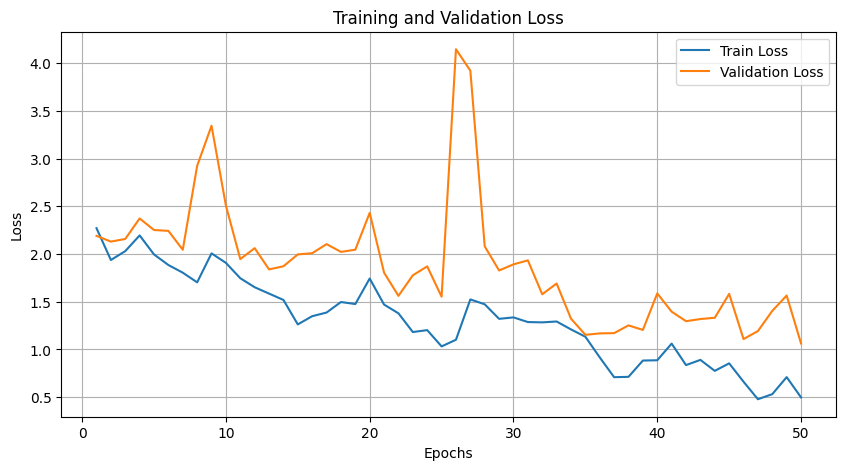

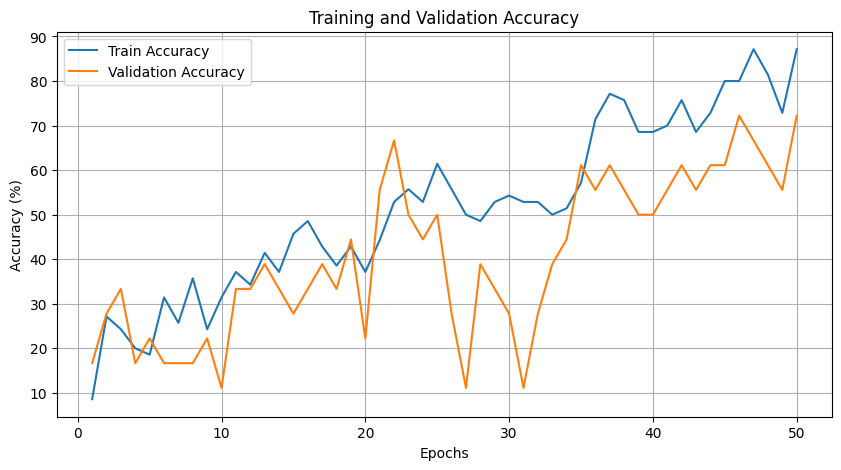

In [353]:
# After the training loop, plot the metrics
epochs_range = range(1, epochs + 1)

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.savefig('img/CNNLSTM_loss')
plt.show()

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid()
plt.savefig('img/CNNLSTM_acc')
plt.show()

In [354]:
# Evaluate on validation set
y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for X_batch, y_batch in val_loader:
        X_batch, y_batch = X_batch, y_batch

        # Forward pass
        outputs = model(X_batch)
        _, preds = torch.max(outputs, 1)

        # Append true and predicted labels
        y_true.extend(y_batch.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

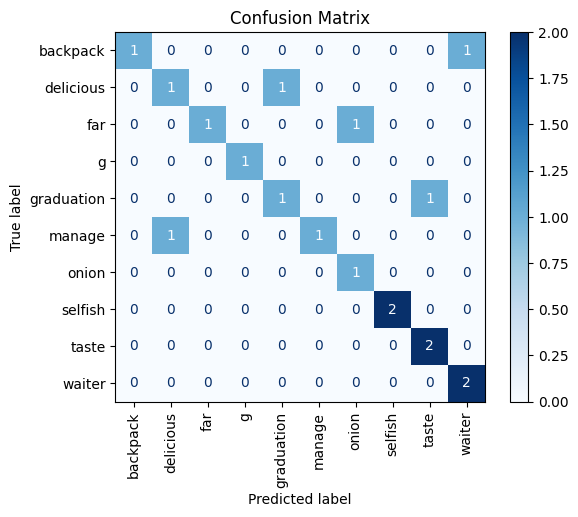

In [355]:
cm = confusion_matrix(y_true, y_pred)

# Display confusion matrix
labels = label_encoder.classes_  # Use your class labels if available
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.savefig('img/CNNLSTM_cm_train')
plt.show()

In [356]:
# Initialize metrics
test_correct = 0
test_total = 0
y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch, y_batch

        # Forward pass
        outputs = model(X_batch)
        _, preds = torch.max(outputs, 1)

        # Collect true and predicted labels
        y_true.extend(y_batch.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

        # Calculate accuracy
        test_correct += (preds == y_batch).sum().item()
        test_total += y_batch.size(0)

# Compute test accuracy
test_accuracy = 100 * test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 72.73%


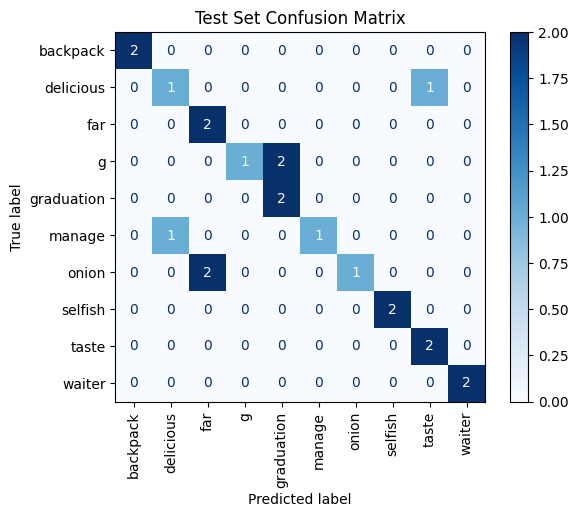

In [358]:
cm = confusion_matrix(y_true, y_pred)

labels = label_encoder.classes_ 
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.title('Test Set Confusion Matrix')
plt.savefig('img/CNNLSTM_test_cm')
plt.show()